In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
from load_dataset import *
import os

['/home/shiqi/code/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']


In [3]:
import yaml

config_path = '/home/shiqi/code/model_combination_Argos/pca_from_formulation/output/experiment_5/config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [4]:
save_dir = config['save_dir']
train_data_dir = config['data_dir']
test_data_dir = '/home/shiqi/code/model_combination_Argos/data_linear_1000_test'

train_loss = np.load(os.path.join(save_dir, 'train_losses.npy'))
test_loss = np.load(os.path.join(save_dir, 'test_losses.npy'))


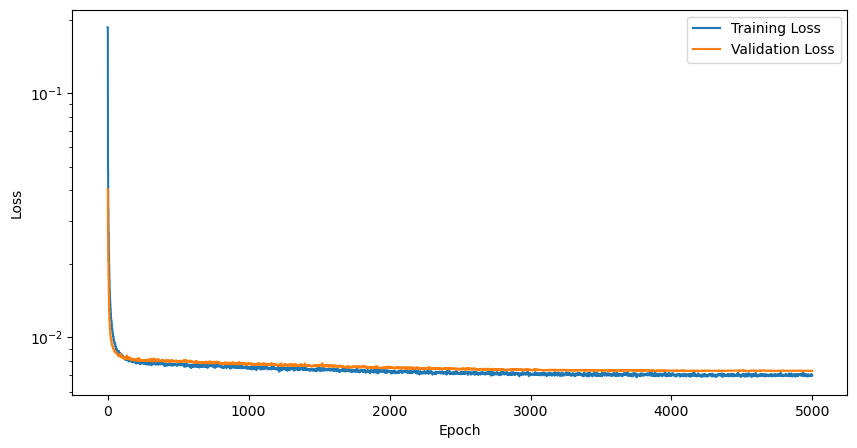

In [5]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [6]:
import pca_koopman_dir as km
import torch
# Device
device = 'cpu'
print('Device:', device)

# todo: multi nu
nu = config['nu']
nu_list = [nu]

# Data loader
x_data, u_data, nu_data, n_features, n_inputs = data_preparation_xu(config, nu_list, nu)

# Params
params = km.Params(n_features, n_inputs, config)

# Model
model = km.build_model(params, x_data, u_data)
model = model.to(device)

Device: cpu


In [7]:
model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth'), map_location=device))

<All keys matched successfully>

In [21]:
begin, end = 50, 150
x_dataset = []
u_dataset = []
window_size = end - begin
data_dir = test_data_dir

for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, _, u_data, _ = load_dataset(data_dict)
        x_dataset.append(x_data[begin:end,:])
        u_dataset.append(u_data[begin:end,:])
    else:
        print(f"File not found: {data_file_path}")

In [22]:
len(x_dataset)
print(x_dataset[0].shape)

(100, 6957)


In [23]:
# start from the zero point
nu = torch.tensor([1000])
x_data_pred_traj = []
x_data_pca_traj = []
x_data_pca_pred_traj = []
nu = torch.tensor(build_nu(nu_list, 1, nu), dtype=torch.int16)
nu = nu.reshape((1, -1))
for x_data, u_data in zip(x_dataset, u_dataset):
    steps = window_size    

    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
    x_pred = torch.zeros_like(x_data).to(device)
    x_pred[0, :] = x_data[0, :]
    x0 = model.encode(x_data[0, :].reshape(1, -1))
    x0 = model.state_dic(x0)
    for step in range(1, steps):
        u = u_data[step-1, :].reshape(1, -1)
        x1 = model.latent_to_latent_forward(x0, u, nu)
        x_pred[step, :] = model.decode(x1)
        x0 = x1
    x_data_pred_traj.append(x_pred.detach().cpu().numpy())
    # print(x_data_pred_traj[-1].shape)
    x_pca_true = model.std_layer_1.transform(x_data.detach())
    x_pca_true = model.pca_transformer.transform(x_pca_true)
    x_pca_true = model.std_layer_2.transform(x_pca_true)
    x_pca_pred = model.std_layer_1.transform(x_pred.detach())
    x_pca_pred = model.pca_transformer.transform(x_pca_pred)
    x_pca_pred = model.std_layer_2.transform(x_pca_pred)
    x_data_pca_traj.append(x_pca_true)
    x_data_pca_pred_traj.append(x_pca_pred)
        



In [24]:
window_size

100

In [25]:
errors = [x_data_pred_traj[i] - x_dataset[i][:window_size, :] for i in range(len(x_data_pred_traj))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

In [26]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

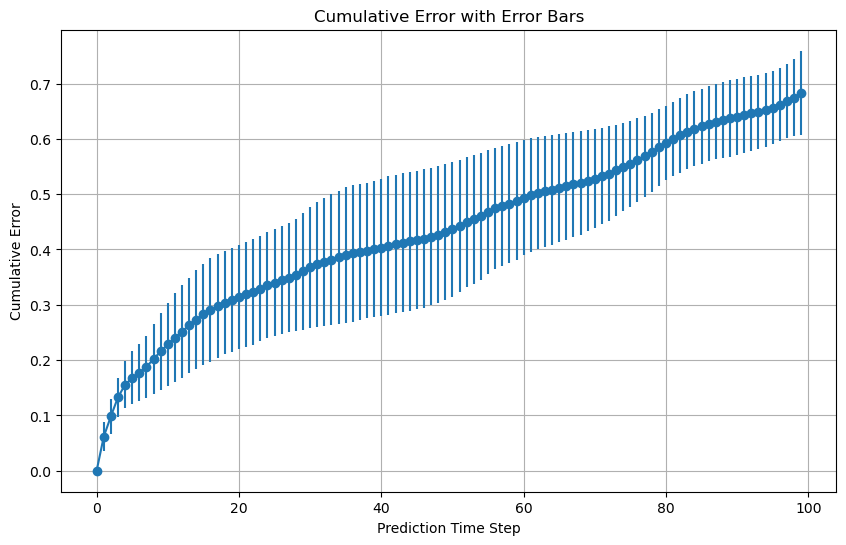

In [27]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(window_size), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
# plt.ylim(0, 0.15)
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [28]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]
print(np.mean(domain_relative_error))

0.6834654545109755


In [29]:
# import numpy as np
# import matplotlib.pyplot as plt

# k = 0  # 假设你已经有了一个数据集索引
# n_dimensions = x_dataset[k].shape[1]  # 假设x_dataset[k]是你的数据
# selected_dimensions = np.random.choice(n_dimensions, 20, replace=False)  # 随机选择20个维度

# # 设置一个4x5的子图网格
# fig, axs = plt.subplots(4, 5, figsize=(20, 16))  # 调整figsize根据你的需求

# # 确保x_true和x_pred已经根据k正确加载
# x_true = x_dataset[k]
# x_pred = x_data_pred_traj[k]

# # 遍历所有选定的维度
# for idx, dim in enumerate(selected_dimensions):
#     # 计算行号和列号
#     row = idx // 5
#     col = idx % 5
    
#     # 在对应的子图上绘图
#     axs[row, col].plot(x_true[:, dim], label='True')
#     axs[row, col].plot(x_pred[:, dim], label='Pred')
#     axs[row, col].set_title(f'Dimension {dim}')
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel('Value')
#     axs[row, col].legend()

# # 调整布局以防止标签重叠
# plt.tight_layout()
# plt.show()


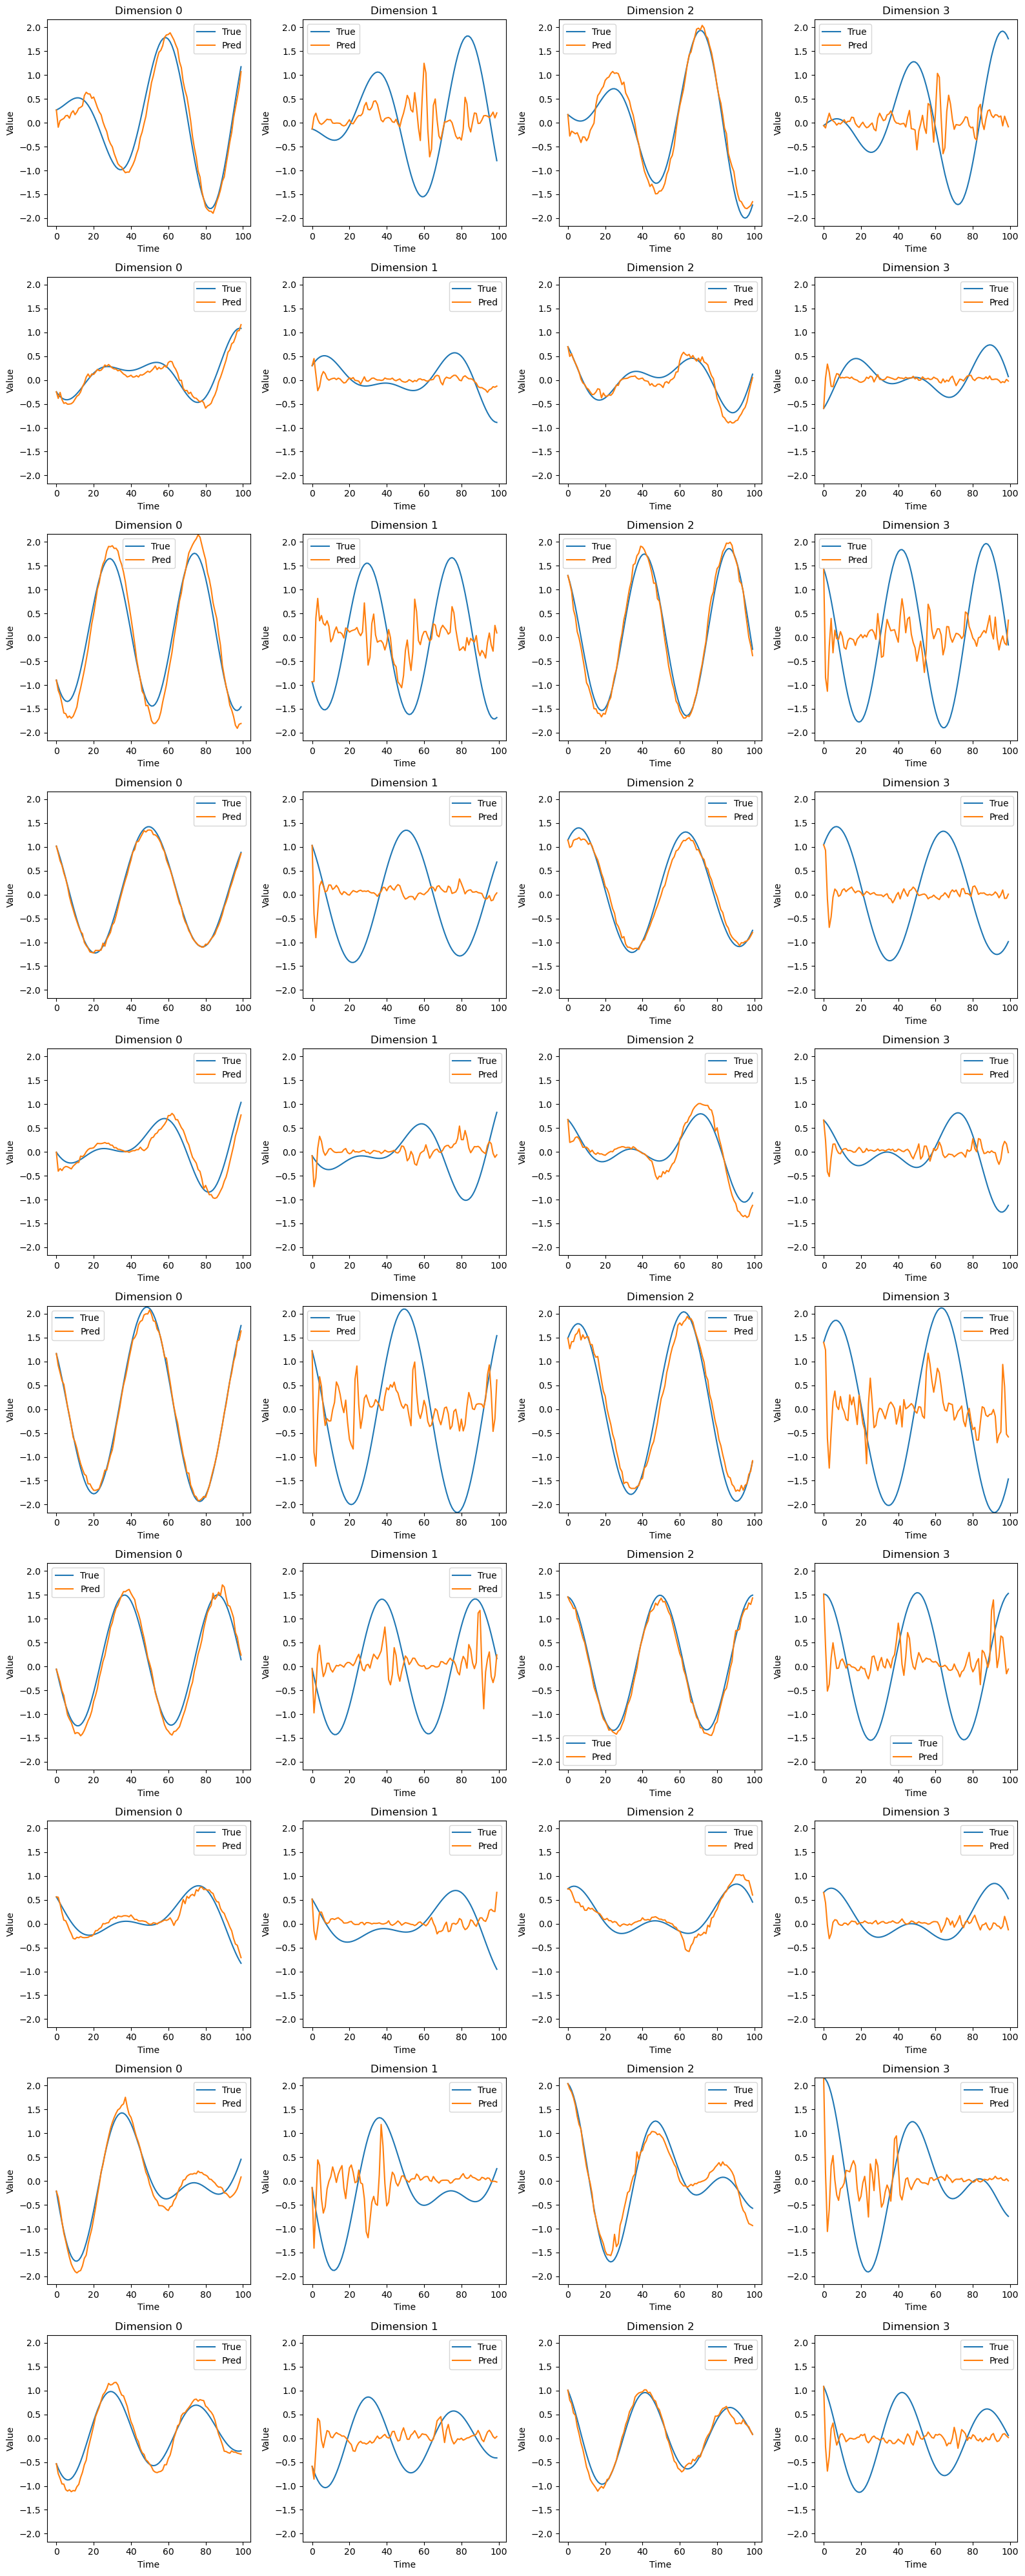

In [30]:
import numpy as np
import matplotlib.pyplot as plt

ks = range(len(x_dataset))  # 选择六个代表性的k值进行绘图

fig, axs = plt.subplots(len(ks), 4, figsize=(16, len(ks) * 4))  # 增加figsize参数以适应更多子图


y_min, y_max = float('inf'), float('-inf')

# 首先遍历所有数据找出全局最小值和最大值
for k in ks:
    x_true = x_data_pca_traj[k]
    x_pred = x_data_pca_pred_traj[k]
    y_min = min(y_min, np.min(x_true.detach().cpu().numpy()))
    y_max = max(y_max, np.max(x_true.detach().cpu().numpy()))

# 遍历每个选定的k值
for idx, k in enumerate(ks):
    x_true = x_data_pca_traj[k]
    x_pred = x_data_pca_pred_traj[k]

    # 遍历前4个维度进行绘图
    for dim in range(4):
        ax = axs[idx, dim]  # 获取对应的子图对象
        ax.plot(x_true[:, dim], label='True')  # 绘制真实值
        ax.plot(x_pred[:, dim], label='Pred')  # 绘制预测值
        ax.set_title(f'Dimension {dim}')  # 设置标题
        ax.set_xlabel('Time')  # 设置x轴标签
        ax.set_ylabel('Value')  # 设置y轴标签
        ax.set_ylim([y_min, y_max])
        ax.legend()  # 显示图例

plt.tight_layout()  # 调整布局
plt.show()  # 显示图形


In [31]:
errors_pca = [x_data_pca_pred_traj[i] - x_data_pca_traj[i] for i in range(len(x_data_pca_pred_traj))]

cumulative_error_norms_pca = []
for k in range(4):
    cur_dim_norm = np.array([np.array([np.linalg.norm(errors_pca[i][:j+1,k]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))])
    cumulative_error_norms_pca.append(cur_dim_norm)




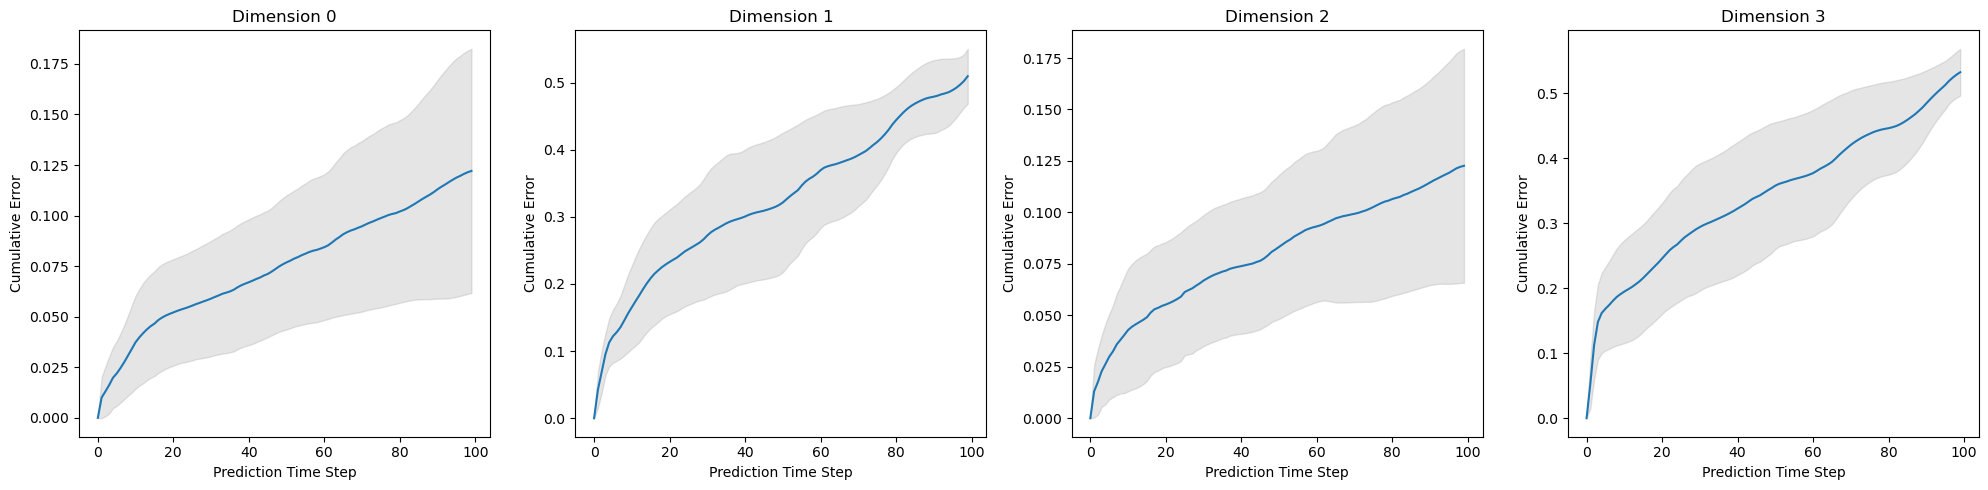

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 window_size, cumulative_error_norms_pca, x_data_pca_traj 等变量已经定义

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 创建一个1行4列的子图布局

for dim in range(4):
    # 计算平均相对误差和标准差
    mean_relative_errors_pca = np.mean([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_data_pca_traj[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)
    std_relative_errors_pca = np.std([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_data_pca_traj[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)

    # 计算上下误差界限
    upper_bound = mean_relative_errors_pca + std_relative_errors_pca
    lower_bound = mean_relative_errors_pca - std_relative_errors_pca

    # 绘制平均误差曲线
    axs[dim].plot(range(window_size), mean_relative_errors_pca, '-', label='Mean Cumulative Error')
    
    # 使用阴影表示误差范围
    axs[dim].fill_between(range(window_size), lower_bound, upper_bound, color='gray', alpha=0.2)

    axs[dim].set_xlabel('Prediction Time Step')
    axs[dim].set_ylabel('Cumulative Error')
    axs[dim].set_title(f'Dimension {dim}')

plt.tight_layout()
plt.show()
